<a href="https://colab.research.google.com/github/sandris1812-wq/DATA-CONURBANIA/blob/main/ProyectoParteIII_Go%C3%B1i.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importación de Librerías**

In [6]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)





# **Carga y Exploración de Datos**

In [26]:
#CARGA DE DATASET

df = pd.read_csv("https://raw.githubusercontent.com/sandris1812-wq/DATA-CONURBANIA/main/conurbania_ds_2000.csv")

df.head()

#EXPLORACIÓN DEL DATASET:  Información de tipo de datos.  Proporción de la variable repeat_customer: se ve que hay mayor porcentaje de clientes que repiten la compra que los que no.

df.info()
df.describe(include="all")
df["repeat_customer"].value_counts(normalize=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_line_id         2000 non-null   int64  
 1   order_id              2000 non-null   int64  
 2   order_date            2000 non-null   object 
 3   customer_id           2000 non-null   object 
 4   repeat_customer       2000 non-null   int64  
 5   region                2000 non-null   object 
 6   channel               2000 non-null   object 
 7   acquisition_source    2000 non-null   object 
 8   campaign              2000 non-null   object 
 9   category              2000 non-null   object 
 10  size                  2000 non-null   object 
 11  color                 2000 non-null   object 
 12  print_type            2000 non-null   object 
 13  design_theme          2000 non-null   object 
 14  dtf_supplier          2000 non-null   object 
 15  dtf_area_cm2         

,proportion
repeat_customer,
1,0.894
0,0.106


# **Definición de variable objetivo y features**

In [13]:
#se determina la variable Y objetivo= reeat_customer .  Se eliminan columanas que no aportan al analisis.  Se le asigna a X todas las columnas que se usarán para predecir

y = df["repeat_customer"]
cols_drop = ["order_id", "order_line_id", "customer_id"]
X = df.drop(columns=cols_drop + ["repeat_customer"], errors="ignore")

X.head()





,order_date,region,channel,acquisition_source,campaign,category,size,color,print_type,design_theme,...,unit_price_final_ars,order_total_ars,cogs_unit_ars,profit_unit_ars,profit_total_ars,delivery_time_days,payment_method,was_returned,defect_type,customer_rating
0,2024-01-02,CABA,TiendaNube,Boca a boca,Ninguna,Remera unisex,XS,Gris,Serigrafía,Tango,...,20520.0,41040.0,12580.46,7939.54,15879.08,5,MercadoPago,0,Ninguno,3.9
1,2024-01-03,Quilmes,Instagram,IG Ads,Ninguna,Remera unisex,M,Gris,DTF,Rock,...,28470.0,28470.0,16341.96,12128.04,12128.04,5,Transferencia,0,Ninguno,4.8
2,2024-01-03,Interior,Instagram,IG Ads,Ninguna,Remera unisex,L,Negro,DTF,Tango,...,27410.0,27410.0,17016.91,10393.09,10393.09,3,Débito,0,Ninguno,4.9
3,2024-01-03,Quilmes,TiendaNube,IG Orgánico,Ninguna,Remera unisex,M,Azul,DTF,Conurbano Nipón,...,25300.0,25300.0,17259.33,8040.67,8040.67,6,Efectivo,0,Ninguno,4.3
4,2024-01-04,CABA,WhatsApp,IG Orgánico,Ninguna,Oversize,M,Negro,Serigrafía,Vintage,...,31810.0,31810.0,19039.18,12770.82,12770.82,4,Efectivo,0,Ninguno,4.1


# **Selección de características**

In [14]:
#se definen columnas numericas y categoricas

numeric_features = X.select_dtypes(include=["number"]).columns.tolist()
categorical_features = X.select_dtypes(exclude=["number"]).columns.tolist()

numeric_features, categorical_features


(['dtf_area_cm2',
  'dtf_cost_per_cm2_ars',
  'base_cost_ars',
  'labor_cost_ars',
  'packaging_cost_ars',
  'shipping_cost_ars',
  'units',
  'price_list_unit_ars',
  'discount_pct',
  'unit_price_final_ars',
  'order_total_ars',
  'cogs_unit_ars',
  'profit_unit_ars',
  'profit_total_ars',
  'delivery_time_days',
  'was_returned',
  'customer_rating'],
 ['order_date',
  'region',
  'channel',
  'acquisition_source',
  'campaign',
  'category',
  'size',
  'color',
  'print_type',
  'design_theme',
  'dtf_supplier',
  'shipping_method',
  'payment_method',
  'defect_type'])

In [15]:
# Se escalan las variables numericas para que los valores no estén en los extremos.  Se aplica el OneHotEncoder a las variables categoricas.  Se seleccionan las mejores variables que ayuden a la predicción de la variable objetivo Repeat_customer

numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

k_features = 10

feature_selector = SelectKBest(score_func=mutual_info_classif, k=k_features)


# **Entrenamiento del modelo**

In [17]:
# Se divide el dataset y se aplica stratify=y para mantener la proporción de clases tanto en el conjunto de entrenamiento como en el de prueba

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [28]:
#Para el entrenamiento del modelo se eligió el algoritmo Regresión Logística, para predecir si el cliente es recurrente o no.

model = LogisticRegression(max_iter=1000, class_weight="balanced")

pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("selector", feature_selector),
    ("classifier", model)
])


In [29]:
pipeline.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.1

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['dtf_area_cm2',
                                                   'dtf_cost_per_cm2_ars',
                                                   'base_cost_ars',
                                                   'labor_cost_ars',
                                                   'packaging_cost_ars',
                                                   'shipping_cost_ars', 'units',
                                                   'price_list_unit_ars',
                                                   'discount_pct',
                                                   'unit_price_final_ars',
                                                   'order_total_ars',
                                                   'cogs_unit_ars',
                                                   'profit_unit_ars',...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['order_date', 'region',
                                                   'channel',
                                                   'acquisition_source',
                                                   'campaign', 'category',
                                                   'size', 'color',
                                                   'print_type', 'design_theme',
                                                   'dtf_supplier',
                                                   'shipping_method',
                                                   'payment_method',
                                                   'defect_type'])])),
                ('selector',
                 SelectKBest(score_func=<function mutual_info_classif at 0x7c07909734c0>)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

# **Métricas de evaluación**

In [30]:
# Métricas para entender el funcionamiento del modelo. Se aplican Accuracy, Precision, Recall, F1-score

y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")


Accuracy : 0.530
Precision: 0.890
Recall   : 0.542
F1-score : 0.674


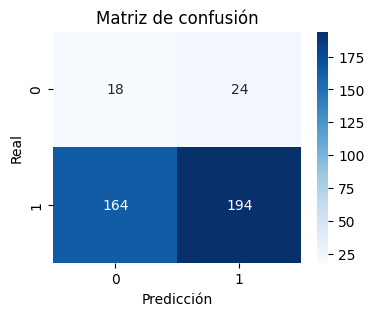

              precision    recall  f1-score   support

           0       0.10      0.43      0.16        42
           1       0.89      0.54      0.67       358

    accuracy                           0.53       400
   macro avg       0.49      0.49      0.42       400
weighted avg       0.81      0.53      0.62       400



In [31]:
#Matriz de confusion

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.show()

print(classification_report(y_test, y_pred))



# **Conclusiones**

En este proyecto trabajé con el dataset original utilizado en el primer trabajo entregado. En esta caso quise predecir si un cliente vuelve a comprar o no. Comence analizando los datos y observé que la variable objetivo (repeat_customer) estaba muy desbalanceada: la gran mayoría de los clientes sí repiten, y muy pocos no lo hacen.
repeat_customer
1	0.894
0	0.106

Igualmente entrene al modelo y predijo siempre la clase mayoritaria, lo cual daba un accuracy alto, pero no servía para distinguir a los clientes que no vuelven.

Para mejorar esto, investigue y apliqué dos técnicas:

Selección de características, usando SelectKBest, para quedarme solo con las variables más relevantes y reducir ruido.

Ajuste del modelo con class_weight="balanced", para que el algoritmo tome en cuenta a la clase minoritaria.

Después de estos ajustes, el modelo empezó a reconocer tanto a los clientes que repiten como a los que no, se acerca a un analisi más realista. La matriz de confusión muestra que el modelo ya no se queda con una sola respuesta, sino que distingue ambas clases. Aunque los valores de precisión y recall no son perfectos, el modelo es ahora más equilibrado y útil para entender mejor el comportamiento de los clientes.

En resumen, el proceso de seleccionar características, entrenar el modelo y ajustar su sensibilidad ante el desbalance permitió obtener un clasificador más representativo. Este modelo puede servir como una primera herramienta para identificar qué clientes podrían no volver, y así tomar decisiones comerciales más inteligentes, como mejorar ofertas, ajustar tiempos de entrega o reforzar campañas de retención.